In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
import selex_dca

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "s100"
round_ids = ["5th", "6th", "7th", "8th"]

In [3]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [87]:
import importlib
importlib.reload(selex_dca)

<module 'selex_dca' from '/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py'>

In [61]:
round_id = round_ids[1]

def parse_header(headers, s):
    header = headers[s]
    parsed = header[3:].split("-")
    assert(float(parsed[0]) == s)
    count = int(parsed[1])
    return count
    
dirpath = "../../Aptamer2025/data/" + experiment_id
filepath = dirpath + "/" + experiment_id + "_" + round_id + ".fasta"
tokens = "ACGT"
headers, sequences = selex_dca.import_from_fasta(filepath, tokens=tokens, filter_sequences=False, remove_duplicates=False)

counts = [parse_header(headers, s) for s in range(len(headers))]
seq = torch.repeat_interleave(torch.tensor(sequences), torch.tensor(counts), dim=0)

In [75]:
torch.stack([torch.tensor(sequences[s]).repeat(counts[s], 1) for s in range(len(headers))], dim=1)

RuntimeError: stack expects each tensor to be equal size, but got [6, 40] at entry 0 and [5, 40] at entry 1

In [88]:
sequences = [selex_dca.sequences_from_file_thrombin(experiment_id, round_id, device) for round_id in round_ids]

In [89]:
pseudo_count = 0

freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[selex_dca.frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [90]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

In [91]:
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg))

In [92]:
nchains = 10000

params = selex_dca.init_parameters(fi=fi) # initialize with frequences at last round
chains = selex_dca.init_chains(num_rounds=n_rounds, num_chains=nchains, L=L, q=q, device=device, fi=fi)

history = selex_dca.init_history()

In [93]:
mask_ps = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask_ps[torch.arange(L), :, torch.arange(L), :] = 0
mask_Ns0 = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask_Ns0[torch.arange(L), :, torch.arange(L), :] = 0

In [94]:
nsweeps = 10
lr = 0.01

ch, par, history = selex_dca.train(
    sampler=sampler,
    chains=chains,
    fi=fi,
    fij=fij,
    total_reads=total_reads,
    params=params,
    mask_ps=mask_ps,
    mask_Ns0=mask_Ns0,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=1000,
    target_pearson=0.95,
    history=history,
    progress_bar=True
    )

 0.00%[                                                       ] Epoch: 0/1000 [00:00]

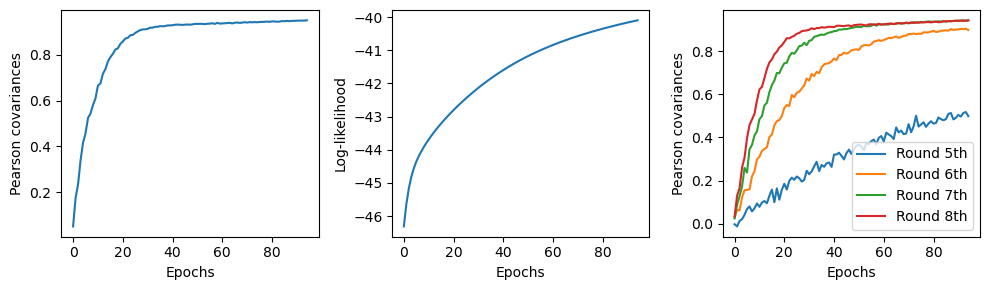

In [95]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot(history["pearson"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Pearson covariances")
ax2.plot(history["log-likelihood"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Log-likelihood")
ax3.plot(history["pearson_rounds"], label=[f"Round {round_ids[r]}" for r in range(n_rounds)])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Pearson covariances")
ax3.legend()
f.tight_layout()

In [116]:
import importlib
importlib.reload(selex_dca)

<module 'selex_dca' from '/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py'>

## Look at learned parameters

In [109]:
params_zerosum = selex_dca.set_zerosum_gauge(params)

In [117]:
F = selex_dca.get_contact_map(params_zerosum["couplings_Ns0"])

<IPython.core.display.Latex object>

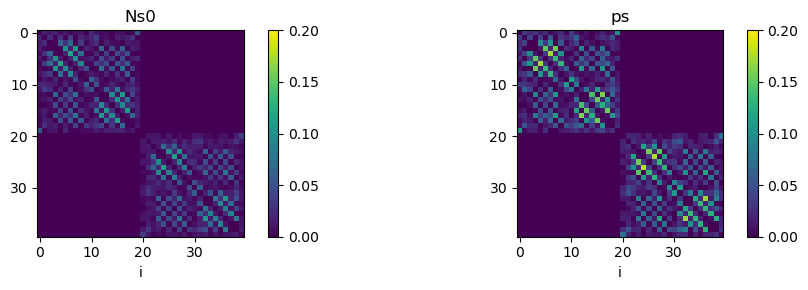

In [121]:
from IPython.display import display, Latex

pl, axes = plt.subplots(1, 2, figsize=(10,3))

J_Ns0 = params_zerosum["couplings_Ns0"]
F = selex_dca.get_contact_map(J_Ns0)
im = axes[0].imshow(F)
axes[0].set_xlabel("i"); ax.set_ylabel("i")
axes[0].set_title("Ns0")
plt.colorbar(im)
im.set_clim(0,0.2)

J_ps = params_zerosum["couplings_ps"]
F = selex_dca.get_contact_map(J_ps)
im = axes[1].imshow(F)
axes[1].set_xlabel("i"); ax.set_ylabel("i")
axes[1].set_title("ps")
plt.colorbar(im)
plt.tight_layout()
im.set_clim(0,0.2)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [138]:
def _select(A, idx):
    A2 = A.index_select(0, torch.tensor(idx))
    return A2.index_select(2, torch.tensor(idx))
    
idx_left = range(0, 20)
idx_right = range(20, 40)

J_ps_left = _select(J_ps, idx_left)
J_ps_right = _select(J_ps, idx_right)
J_Ns0_left = _select(J_Ns0, idx_left)
J_Ns0_right = _select(J_Ns0, idx_right)

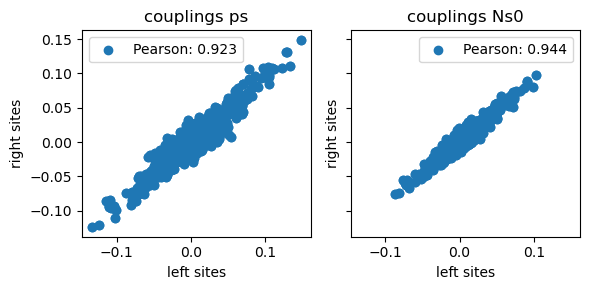

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3), sharex=True, sharey=True)
ax = ax1
x = J_ps_left.view(-1)
y = J_ps_right.view(-1)
rho = torch.corrcoef(torch.stack((x,y)))[0,1]
ax.scatter(x, y, label=f"Pearson: {rho:.3f}")
ax.set_xlabel("left sites")
ax.set_ylabel("right sites")
ax.set_title("couplings ps")
ax.legend()

ax = ax2
x = J_Ns0_left.view(-1)
y = J_Ns0_right.view(-1)
rho = torch.corrcoef(torch.stack((x,y)))[0,1]
ax.scatter(x, y, label=f"Pearson: {rho:.3f}")
ax.set_xlabel("left sites")
ax.set_ylabel("right sites")
ax.set_title("couplings Ns0")
ax.legend()

plt.tight_layout()

## Compare against empirical enrichments

In [96]:
logNst, sequences_unique, inverse_indices, counts = selex_dca.compute_logNst(sequences, params)

In [98]:
logNst_thresh = -200
count_thresh = 0

In [99]:
ts = range(len(round_ids))
X, Y = zip(*[
    selex_dca.vectors_for_scatterplot_single_t_unique(logNst[t], counts[t], 
                                                      logNst_thresh=logNst_thresh,
                                                      count_thresh=count_thresh)
    for t in ts])

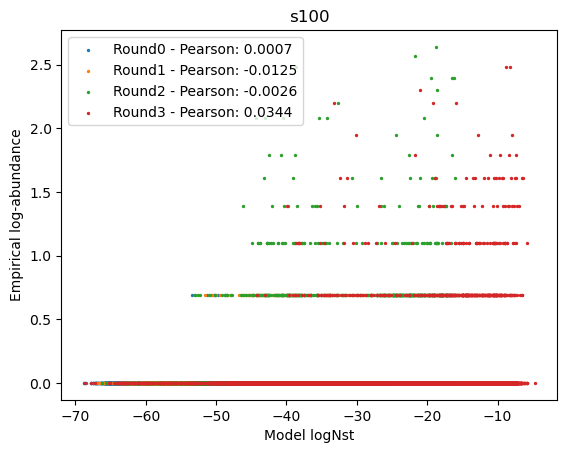

In [100]:
import random
N = 10**5

fig, ax = plt.subplots()

for t in ts:
    x = X[t]; y = Y[t]
    pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
    idx = random.sample(range(len(x)),min(N, len(x)))
    ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
    ax.set_xlabel("Model logNst")
    ax.set_ylabel("Empirical log-abundance")
    ax.set_title(f"{experiment_id}")
ax.legend();